In [9]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import re
import dateutil.parser 
import datetime
import math
import locale
import os
locale.setlocale(locale.LC_ALL,'en_US')


def getTransfersFile(league,season):
    filename = league + "_" + str(season)
    result = pd.read_csv("../data/transfers/" + filename + ".csv")
    result['filename'] = filename
    return result

def getPersonalFile(league,season):
    filename = league + "_" + str(season)
    result = pd.read_csv("../data/personal/" + filename + ".csv")
    result['filename'] = filename
    return result
    
def getClubFile(group,season):
    filename = group + "_" + str(season)
    result = pd.read_csv("../data/clubs/" + filename + ".csv")
    result['filename'] = filename
    result['season'] = season
    return result

def mvFix(mv):
    if 'Mill.' in mv:
        return float(mv.split('Mill.')[0].replace(',','.'))*1000000
    elif "Th." in mv:
        return float(mv.split('Th.')[0].replace(',','.'))*1000
    elif "-" in mv or "?"==mv:
        return np.nan
    else:
        return int('0' + ''.join([d for d in mv.replace(',','.') if d in '1234567890.']))

def feeValue(mv):
    try:
        mv = str(mv)
        r= mvFix(mv.replace('Loan fee:',''))
        return r
    except Exception as e:
        print mv, e
        return -666

def heightFix(h):
    r = float('0' + ''.join([d for d in str(h).replace(',','.') if d in '1234567890.']))
    return r if r > 0 else np.nan

def getAge(born, today):
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def getAgeWithSeasonAdjustment(born,today,season):
    if type(today) == int:
        return (today.year if today.year in [season,season+1] else season) - born.year - ((today.month, today.day) < (born.month, born.day))
    else:
        return season - born.year

def getAgeFloatWithSeasonAdjustment(born,today,season):
    if type(today) == int:
        return (today if today.year in [season,season+1] else datetime.datetime(season,today.month,today.day)) - born
    else:
        return datetime.datetime(season,1,1) - born
    
def parsedate(d):
    try:
        if d=="-":
            return np.nan
        return dateutil.parser.parse(str(d)) if pd.notnull(d) else np.nan
    except Exception as e:
        t=str(d).split('.')
        d='.'.join([str(int(t[0])-1)] + t[1:])
        try:
            return dateutil.parser.parse(str(d))
        except Exception as e2:
            print d
            #print e2
            return np.nan
    
def parsebirthdate(d):
    return parsedate(str(d).replace(' Happy Birthday','')) if pd.notnull(d) else np.nan

def basicparse(d):
    try:
        return dateutil.parser.parse(d)
    except Exception as e:
        #print e
        return np.nan

def seasonFix(season):
    year = int(season[-5:].split('/')[0])
    return year+2000 if year < 20 else year+1900

def camel(s):
    words = [''.join([c for c in w if c.isalnum()]) for w in s.split(' ')]
    result = [words[0].lower()]
    result.extend([w.title() for w in words[1:]])
    return ''.join(result)

def agentIdToInt(i):
    if 'nan' in str(i):
        return -1
    try:
        return int(str(i).split('.')[0])
    except Exception:
        return -18
    
leagueList = ['GB1','ES1','L1','IT1','FR1','PO1','NL1','TR1','RU1','BE1','MLS1','UKR1','GR1','RO1','ZYP1','KR1','SER1','BOS1','BU1','DK1','SE1','NO1','LI1','SC1','ISR1','PL1','UNG1','A1','C1','MAL1','KAS1','TS1','SLO1','SL1','FI1','LUX1','AZ1']

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [ ]:
#TODO
get national team id -> nation team name mapping
defunct competitions
check actual season ranges  of competitions

In [3]:
players0 = pd.concat([getPersonalFile(league,season) for league in leagueList for season in range(2001,2016) if os.path.isfile("../data/personal/" + league + "_" + str(season) + ".csv")],ignore_index=True)
players = players0[pd.notnull(players0['Display name'])].copy()
players = players.drop_duplicates('id') #27081
players = players.drop(['error','birthDate','filename','name'],axis=1,errors='ignore')
players['Date of birth']=players['Date of birth'].apply(parsebirthdate)
players['Height']=players['Height'].apply(heightFix)
players['Nationality 2']=players['Nationality'].str.split(' \xc2\xa0\xc2\xa0',expand=True)[1]
players['Nationality']=players['Nationality'].str.split(' \xc2\xa0\xc2\xa0',expand=True)[0]
players['Position group']=players["Position"].str.split(" - ",expand=True)[0]
players['Position']=players["Position"].str.split(" - ",expand=True)[1]
players['Intl caps']=players['Intl caps/goals'].str.split('/',expand=True)[0]
players['Intl goals']=players['Intl caps/goals'].str.split('/',expand=True)[1]
del players['Intl caps/goals']
players['In the team since']=players['In the team since'].apply(parsedate)
players['Contract until']=players['Contract until'].apply(parsedate)
players['Contract there until']=players['Contract there until'].apply(parsedate)
players['2nd club']=players['2nd club'].str.replace('\(#\d+\)','').str.strip()
players['Date of last contract extension']=players['Date of last contract extension'].apply(parsedate)
players['Main position']=players['Detailed position'].str.split('Side position:',expand=True)[0].str.slice(start=14)
players['Side position']=players['Detailed position'].str.split('Side position:',expand=True)[1]
del players['Detailed position']
players['Glove']=players['Glove'].str.split(' since ',expand=True)[0]
players['Shoe model']=players['Shoe model'].str.split(' since ',expand=True)[0]
players["Shoe size"]=players["Shoe size"].apply(lambda s:float(str(s).replace(",",".")))
players['day of death']=players['day of death'].str.slice(stop=10).apply(parsedate)
players['id'].apply(int)
c = ['id','Display name', 'Name in home country','Date of birth','Place of birth','Country of birth',
        'Age','Height','Nationality','Nationality 2','Position group','Position','Main position','Side position',
        'Foot','National team id', 'Intl caps','Intl goals','Player\'s agent','Player\'s agent id', 
        'Current club', 'Current club id','In the team since', 'Contract until','on loan from', 'on loan from club id', 'Contract there until']

players = players[(c + [x for x in players.columns if not x in c])]
players.index = players['id']

14.20.2019
month must be in 1..12


In [4]:
clubs0 = pd.concat([getClubFile(group,season) for group in ['top','bottom','other','americas','world','deeper'] for season in range(1992,2016)],ignore_index=True)
clubs=clubs0.copy()
clubs = clubs[~((clubs['league']=='GB2')&(clubs['season']<2004))].copy()
clubs = clubs[~((clubs['league']=='GB3')&(clubs['season']<2004))]
clubs = clubs[~((clubs['league']=='ENSD')&(clubs['season'].isin([2002,2003])))]
clubs = clubs[~((clubs['league']=='EFD2')&(clubs['season'].isin([2001,2002,2003])))]
clubs = clubs[~((clubs['league']=='IT2')&(clubs['season']<1993))]
clubs = clubs[~((clubs['league']=='IT3A')&(clubs['season']<2006))]
clubs = clubs[~((clubs['league']=='IT3B')&(clubs['season']<2007))]
clubs = clubs[~((clubs['league']=='IT3C')&(clubs['season']<2014))]
clubs = clubs[~((clubs['league']=='ITJ1')&(clubs['season']<2009))]
clubs = clubs[~((clubs['league']=='ITJ2')&(clubs['season']<2009))]
clubs = clubs[~((clubs['league']=='ITJ3')&(clubs['season']<2008))]
clubs = clubs[~((clubs['league']=='L3')&(clubs['season']<2008))]
clubs = clubs[~((clubs['league'].isin(["RLW3","RLSW","RLN3","RLN4","RLB3"]))&(clubs['season']<2012))]
clubs = clubs[~((clubs['league']=='BE1')&(clubs['season']<2000))]
clubs = clubs[~((clubs['league']=='BE2')&(clubs['season']<2005))]
clubs = clubs[~((clubs['league']=='FR2')&(clubs['season']<1995))]
clubs = clubs[~((clubs['league']=='FR2')&(clubs['season']<2001))]
clubs = clubs[~((clubs['league']=='PO1')&(clubs['season']<2003))]
clubs = clubs[~((clubs['league']=='PO2')&(clubs['season']<2004))]
clubs = clubs[~((clubs['league']=='RU1')&(clubs['season']<2004))]
clubs = clubs[~((clubs['league']=='RU2')&(clubs['season']<2006))]
clubs = clubs[~((clubs['league']=='MLS1')&(clubs['season']<1995))]
clubs = clubs[~((clubs['league']=='NAFC')&(clubs['season']<2012))]
clubs = clubs[~((clubs['league']=='BRA1')&(clubs['season']<2004))]
clubs = clubs[~((clubs['league']=='BRA2')&(clubs['season']<2007))]
clubs = clubs[~((clubs['league']=='TR2')&(clubs['season']<2001))]
clubs = clubs[~((clubs['league']=='ES3A')&(clubs['season']<1998))]
clubs = clubs[~((clubs['league']=='ES3B')&(clubs['season']<2000))]
clubs = clubs[~((clubs['league']=='ES3C')&(clubs['season']<2006))]
clubs = clubs[~((clubs['league']=='ES3D')&(clubs['season']<2011))]
clubs = clubs[~((clubs['league']=='510')&(clubs['season']<2010))]
clubs = clubs[~((clubs['league']=='511')&(clubs['season']<2010))]
clubs = clubs[~((clubs['league']=='TR3A')&(clubs['season']<2010))]
clubs = clubs[~((clubs['league']=='TR3B')&(clubs['season']<2010))]
clubs = clubs[~((clubs['league']=='TR4A')&(clubs['season']<2012))]
clubs = clubs[~((clubs['league']=='TR4B')&(clubs['season']<2012))]
clubs = clubs[~((clubs['league']=='TR4C')&(clubs['season']<2013))]
clubs = clubs[~((clubs['league']=='GB4')&(clubs['season']<2004))]
clubs = clubs[~((clubs['league']=='CNAT')&(clubs['season']<2010))]
clubs = clubs[~((clubs['league']=='EFD2')&(clubs['season']<2001))]
clubs = clubs[~((clubs['league']=='EFD2')&(clubs['season']>2003))]
clubs = clubs[~((clubs['league']=='ENSD')&~(clubs['season'].isin([2002,2003])))]

clubs = clubs[~((clubs['clubId']==2457)&(clubs['season']==2006)&(clubs['league']=='PO2'))]
clubs = clubs[~((clubs['clubId'].isin([11126,11127]))&(clubs['season']==2011)&(clubs['league']=='RU1'))]
#clubs

In [14]:
transfers0 = pd.concat([getTransfersFile(league,season) for league in leagueList for season in range(2001,2016) if os.path.isfile("../data/transfers/" + league + "_" + str(season) + ".csv")],ignore_index=True)
transfers = transfers0[pd.notnull(transfers0['playerName'])].copy()
transfers['date'] = transfers['date'].apply(basicparse)
transfers['season']=transfers['season'].apply(seasonFix)
transfers=transfers.merge(clubs.rename(columns={'league': 'fromLeague','clubId':'fromTeamId'})[['fromTeamId','season','fromLeague']],how='left',on=['season','fromTeamId']) \
                .merge(clubs.rename(columns={'league': 'toLeague','clubId':'toTeamId'})[['toTeamId','season','toLeague']],how='left',on=['season','toTeamId'])
transfers=transfers[['id','playerName','date','season','fromCountry','fromLeague','fromTeamId','fromTeamName','toCountry','toLeague','toTeamId','toTeamName','mv','fee']]
transfers=transfers.merge(players,how='left',on='id')
transfers['mv'] = transfers['mv'].apply(mvFix)
transfers['feeValue'] = transfers['fee'].apply(feeValue)
transfers=transfers.drop_duplicates()
transfers=transfers[(transfers['fee']!='End of loan')]
transfers['isLoan']=(transfers['fee'].str.startswith('Loan')).fillna(False)
#outofrangeIds = transfers[(transfers['season']<1992)]['id'].drop_duplicates().tolist()
#transfers=transfers[~transfers['id'].isin(outofrangeIds)]
transfers=transfers[transfers['season']<2016]
transfers['toCountry']=np.where(transfers['fromTeamId'].isin([75,123,515,2113,2077]),transfers['fromCountry'],transfers['toCountry'])
transfers['toCountry']=np.where(transfers['toTeamName'].str.startswith('Monaco'),'France',transfers['toCountry'])
transfers['fromCountry']=np.where(transfers['fromTeamId'].isin([75,123,515,2113,2077]),np.nan,transfers['fromCountry'])
transfers['fromCountry']=np.where(transfers['fromTeamName'].str.startswith('Monaco'),'France',transfers['fromCountry'])
transfers['toCountry']=np.where(transfers['fromTeamId'].isin([464,12604]),transfers['fromCountry'],transfers['toCountry'])
transfers['fromLeague']=np.where(pd.isnull(transfers['fromLeague']),'Other '+transfers['fromCountry'],transfers['fromLeague'])
transfers['toLeague']=np.where(pd.isnull(transfers['toLeague']),'Other '+transfers['toCountry'],transfers['toLeague'])
transfers['fromCountry']=np.where(transfers['fromLeague']=='MLS1','United States',transfers['fromCountry'])
transfers['toCountry']=np.where(transfers['toLeague']=='MLS1','United States',transfers['toCountry'])
transfers['fromCountry']=np.where(transfers['fromCountry'].str.startswith('Liechten'),'Switzerland',transfers['fromCountry'])
transfers['toCountry']=np.where(transfers['toCountry'].str.startswith('Liechten'),'Switzerland',transfers['toCountry'])
transfers['age']=transfers[['Date of birth','date','season']].apply(lambda x:getAgeWithSeasonAdjustment(*x),axis=1)
transfers['ageFloat']=transfers[['Date of birth','date','season']].apply(lambda x:getAgeFloatWithSeasonAdjustment(*x),axis=1)/ np.timedelta64(1, 'Y')
transfers['period']=pd.cut(transfers['season'],[1995,2000,2005,2010,2015])
transfers=transfers.rename(columns={x:camel(x) for x in transfers.columns if ' ' in x})
transfers.toTeamId=transfers.toTeamId.apply(int)
transfers.fromTeamId=transfers.fromTeamId.apply(int)
transfers.toTeamName=transfers.toTeamName.str.strip()
transfers.fromTeamName=transfers.fromTeamName.str.strip()
transfers.intlCaps=transfers.intlCaps.fillna(0).apply(int)
transfers.intlGoals=transfers.intlGoals.fillna(0).apply(int)
transfers.currentClubId=transfers.currentClubId.apply(int)
transfers.nationalTeamId=transfers.nationalTeamId.fillna(-1).apply(int)
transfers.playersAgentId=transfers.playersAgentId.apply(agentIdToInt)
loans=transfers[transfers['isLoan']]
nonloans=transfers[~transfers['isLoan']]

String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String does not contain a date.
String d

In [17]:
transfers['fromCountry']=np.where(transfers['fromCountry'].str.startswith('Liechten'),'Switzerland',transfers['fromCountry'])
transfers['toCountry']=np.where(transfers['toCountry'].str.startswith('Liechten'),'Switzerland',transfers['toCountry'])
loans=transfers[transfers['isLoan']]
nonloans=transfers[~transfers['isLoan']]

In [47]:
dateutil.parser.parse('Jan 1, 2009 ')

datetime.datetime(2009, 1, 1, 0, 0)

In [18]:
transfers.to_csv('../data/merged/transfers.csv',encoding='utf-8',index=False)
loans.to_csv('../data/merged/loans.csv',encoding='utf-8',index=False)
nonloans.to_csv('../data/merged/nonloans.csv',encoding='utf-8',index=False)
players.to_csv('../data/merged/players.csv',encoding='utf-8',index=False)

In [313]:

{c:str(transfers[c].dtype) for c in transfers.columns if c.endswith('Id')}

{'2ndClubId': 'float64',
 'currentClubId': 'int64',
 'fromTeamId': 'int64',
 'nationalTeamId': 'int64',
 'onLoanFromClubId': 'float64',
 'playersAgentId': 'int64',
 'toTeamId': 'int64'}

In [309]:
def agentIdToInt(i):
    if 'nan' in str(i):
        return -1
    try:
        return int(str(i).split('.')[0])
    except Exception:
        return -18
    
transfers[['id','playersAgentId','playersAgent']]

x=transfers[['id','playersAgentId','playersAgent']].join(transfers['playersAgentId'].apply(agentIdToInt),rsuffix='_new')
x[x.playersAgentId_new<0].drop_duplicates('playersAgentId')

,id,playersAgentId,playersAgent,playersAgentId_new
0,4096,NaN,NaN,-1
52590,316264,Agent is known players under 18:,Agent is known players under 18:,-18


In [268]:
players[players['id']==17340 ]['Player\'s agent id'].apply(str).apply(int)

ValueError: invalid literal for int() with base 10: '2400.0'

In [255]:
a='asdasd'
'12a1212'.isdigit()

False

In [162]:
fromIds=transfers.sort_values('season',ascending=False).drop_duplicates('fromTeamId')[['fromTeamId','fromTeamName']]
toIds=transfers.sort_values('season',ascending=False).drop_duplicates('fromTeamId')[['toTeamId','toTeamName']]

,fromTeamId,fromTeamName
179664,12511,Kocaeli Birlik


In [176]:
teamIdMap = pd.concat([transfers[['toTeamId','toTeamName','season']].rename(columns={'toTeamId':'teamId','toTeamName':'teamName'}),
    transfers[['fromTeamId','fromTeamName','season']].rename(columns={'fromTeamId':'teamId','fromTeamName':'teamName'})],ignore_index=True) \
    .sort_values('season',ascending=False).drop_duplicates('teamId').set_index('teamId')['teamName'].to_dict()

In [332]:
x=transfers.groupby('playersAgentId')['playersAgent'].nunique().sort_values()
transfers[transfers['playersAgentId'].isin([y for y in x[x>1].index])][['playersAgentId','playersAgent']].sort_values('playersAgent',ascending=False).drop_duplicates('playersAgentId')

,playersAgentId,playersAgent
250423,847,Proeleven Gestão Desportiva Lda
90670,348,PDP s.r.l. Pasqualin D’Amico Partners
131267,1881,Meïssa N'diaye
75684,302,Kögl & Partner GmbH


In [338]:
agentIdMap = transfers[['playersAgentId','playersAgent']].sort_values('playersAgent',ascending=False).drop_duplicates('playersAgentId').set_index('playersAgentId')['playersAgent'].to_dict()

In [87]:
transfers[transfers['Date of birth'].isnull()].count() #.apply(lambda x: x.day).value_counts().sort_index().plot.bar()

id                                 9
playerName                         9
date                               9
season                             9
fromCountry                        9
fromLeague                         9
fromTeamId                         9
fromTeamName                       9
toCountry                          7
toLeague                           7
toTeamId                           9
toTeamName                         9
mv                                 0
fee                                9
Display name                       9
Name in home country               0
Date of birth                      0
Place of birth                     0
Country of birth                   0
Age                                0
Height                             4
Nationality                        9
Nationality 2                      1
Position group                     9
Position                           0
Main position                      1
Side position                      0
F

In [93]:
transfers['Place of birth'].str.strip().drop_duplicates().sort_values().count()

7511

TypeError: range() integer end argument expected, got str.

In [111]:


{x:camel(x) for x in transfers.columns if ' ' in x}



,id,playerName,date,season,fromCountry,fromLeague,fromTeamId,fromTeamName,toCountry,toLeague,...,shoeSize,dayOfDeath,facebook,instagram,twitter,website,feeValue,isLoan,AgeFloat,period
0,4096,Jacob Burns,2014-07-01,2014,Australia,AUS1,970.0,Perth Glory,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,36.195131,"(2010, 2015]"
1,4096,Jacob Burns,2009-07-01,2009,Romania,RO1,10442.0,Unirea Urziceni,Australia,AUS1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,31.195712,"(2005, 2010]"
2,4096,Jacob Burns,2008-02-01,2007,Poland,PL1,422.0,Wisla Kraków,Romania,RO1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,29.782952,"(2005, 2010]"
3,4096,Jacob Burns,2006-02-01,2005,England,GB3,349.0,Barnsley FC,Poland,PL1,...,NaN,NaN,NaN,NaN,NaN,NaN,100000.0,False,27.784280,"(2000, 2005]"
4,4096,Jacob Burns,2004-01-01,2003,NaN,NaN,515.0,Unattached,England,Other England,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,25.697995,"(2000, 2005]"
5,4096,Jacob Burns,2003-07-01,2003,England,GB1,399.0,Leeds,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,25.194220,"(2000, 2005]"
6,4096,Jacob Burns,2000-07-01,2000,Australia,Other Australia,2500.0,Parra. Power,England,GB1,...,NaN,NaN,NaN,NaN,NaN,NaN,375000.0,False,22.196212,"(1995, 2000]"
7,4096,Jacob Burns,1999-07-01,1999,Australia,Other Australia,6045.0,Sydney United,Australia,Other Australia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,21.194138,"(1995, 2000]"
8,4097,Kevin Lisbie,2016-01-11,2015,England,GB4,2804.0,Barnet,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,37.235535,"(2010, 2015]"
9,4097,Kevin Lisbie,2015-07-01,2015,England,GB4,1150.0,Leyton Orient,England,GB4,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,36.704381,"(2010, 2015]"


In [125]:
transfers #['fromTeamId']

,id,playername,date,season,fromcountry,fromleague,fromteamid,fromteamname,tocountry,toleague,...,shoeSize,dayOfDeath,facebook,instagram,twitter,website,feevalue,isloan,agefloat,period
0,4096,Jacob Burns,2014-07-01,2014,Australia,AUS1,970.0,Perth Glory,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,36.195131,"(2010, 2015]"
1,4096,Jacob Burns,2009-07-01,2009,Romania,RO1,10442.0,Unirea Urziceni,Australia,AUS1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,31.195712,"(2005, 2010]"
2,4096,Jacob Burns,2008-02-01,2007,Poland,PL1,422.0,Wisla Kraków,Romania,RO1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,29.782952,"(2005, 2010]"
3,4096,Jacob Burns,2006-02-01,2005,England,GB3,349.0,Barnsley FC,Poland,PL1,...,NaN,NaN,NaN,NaN,NaN,NaN,100000.0,False,27.784280,"(2000, 2005]"
4,4096,Jacob Burns,2004-01-01,2003,NaN,NaN,515.0,Unattached,England,Other England,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,25.697995,"(2000, 2005]"
5,4096,Jacob Burns,2003-07-01,2003,England,GB1,399.0,Leeds,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,25.194220,"(2000, 2005]"
6,4096,Jacob Burns,2000-07-01,2000,Australia,Other Australia,2500.0,Parra. Power,England,GB1,...,NaN,NaN,NaN,NaN,NaN,NaN,375000.0,False,22.196212,"(1995, 2000]"
7,4096,Jacob Burns,1999-07-01,1999,Australia,Other Australia,6045.0,Sydney United,Australia,Other Australia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,21.194138,"(1995, 2000]"
8,4097,Kevin Lisbie,2016-01-11,2015,England,GB4,2804.0,Barnet,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,37.235535,"(2010, 2015]"
9,4097,Kevin Lisbie,2015-07-01,2015,England,GB4,1150.0,Leyton Orient,England,GB4,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,36.704381,"(2010, 2015]"


In [50]:
players[players['id']== 146494 ]

,id,Display name,Name in home country,Date of birth,Place of birth,Country of birth,Age,Height,Nationality,Nationality 2,...,Date of last contract extension,Glove,Outfitter,Shoe model,Shoe size,day of death,facebook,instagram,twitter,website
id,,,,,,,,,,,,,,,,,,,,,
146494.0,146494.0,Anthony Forde,NaN,1993-11-16,"Ballingarry, County Limerick",Ireland,22.0,1.77,Ireland,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
players

,id,Display name,Name in home country,Date of birth,Place of birth,Country of birth,Age,Height,Nationality,Nationality 2,...,Date of last contract extension,Glove,Outfitter,Shoe model,Shoe size,day of death,facebook,instagram,twitter,website
id,,,,,,,,,,,,,,,,,,,,,
4.0,4.0,Youri Djorkaeff,Youri Raffi Djorkaeff,1968-03-09,Lyon,France,48.0,1.79,France,Armenia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104.0,104.0,Fredi Bobic,Fredi Bobič,1971-10-30,Maribor,Jugoslawien (SFR),44.0,1.87,Germany,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.fredibobic.de
192.0,192.0,Markus Babbel,NaN,1972-09-08,München,Germany,43.0,1.91,Germany,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205.0,205.0,Nils-Eric Johansson,NaN,1980-01-13,Stockholm,Sweden,36.0,1.87,Sweden,None,...,2015-07-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301.0,301.0,Thomas Gravesen,NaN,1976-03-11,Vejle,Denmark,40.0,1.78,Denmark,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
324.0,324.0,Stig Töfting,Stig Tøfting,1969-08-14,Aarhus,Denmark,46.0,1.76,Denmark,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669.0,669.0,Brian O'Neil,NaN,1972-09-06,Paisley,Scotland,43.0,1.85,Scotland,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
916.0,916.0,Christian Ziege,NaN,1972-02-01,Berlin,Germany,44.0,1.86,Germany,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
919.0,919.0,Dietmar Hamann,NaN,1973-08-27,Waldsassen,Germany,42.0,1.88,Germany,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
transfers['Age']=transfers[['Date of birth','date','season']].apply(lambda x:getAgeWithSeasonAdjustment(*x),axis=1)/ np.timedelta64(1, 'Y')
transfers[transfers['date'].apply(lambda x:x.year)<transfers['season']][['Date of birth','date','season','Age']]

,Date of birth,date,season,Age
27680,1995-06-30,2012-07-01,2013,17.005140
27871,1996-09-02,2014-10-01,2015,18.078400
29898,1994-05-27,2011-07-01,2012,17.095491
30471,1984-06-27,2006-07-01,2007,22.010034
37401,1983-05-04,2002-07-01,2003,19.159873
43823,1982-02-09,2004-07-01,2005,22.390604
51845,1988-10-08,2011-08-31,2012,22.894378
64350,1976-09-16,2007-07-01,2010,30.787764
64722,1979-09-06,2012-07-01,2013,32.819291
88549,1977-02-21,2014-07-01,2015,37.356003


In [17]:
transfers.columns

Index([u'id', u'playerName', u'date', u'season', u'fromCountry', u'fromLeague',
       u'fromTeamId', u'fromTeamName', u'toCountry', u'toLeague', u'toTeamId',
       u'toTeamName', u'mv', u'fee', u'Display name', u'Name in home country',
       u'Date of birth', u'Place of birth', u'Country of birth', u'Age',
       u'Height', u'Nationality', u'Nationality 2', u'Position group',
       u'Position', u'Main position', u'Side position', u'Foot',
       u'National team id', u'Intl caps', u'Intl goals', u'Player's agent',
       u'Player's agent id', u'Current club', u'Current club id',
       u'In the team since', u'Contract until', u'on loan from',
       u'on loan from club id', u'Contract there until', u'2nd club',
       u'2nd club id', u'Complete name', u'Contract option',
       u'Date of last contract extension', u'Glove', u'Outfitter',
       u'Shoe model', u'Shoe size', u'day of death', u'facebook', u'instagram',
       u'twitter', u'website', u'feeValue', u'isLoan'],
      dtype=

In [11]:
transfers[transfers['Age']==4]

,id,playerName,date,season,fromCountry,fromLeague,fromTeamId,fromTeamName,toCountry,toLeague,...,Outfitter,Shoe model,Shoe size,day of death,facebook,instagram,twitter,website,feeValue,isLoan
73932,89591,Felix Klaus,1997-07-01,1997,Germany,Other Germany,40042.0,Bösensell Jgd.,Germany,Other Germany,...,NaN,NaN,NaN,NaN,https://www.facebook.com/FelixKlaus36,https://www.instagram.com/fk_11/,NaN,NaN,0.0,False


In [24]:
pd.concat(,axis=1)

TypeError: concat() got multiple values for keyword argument 'axis'

In [10]:
print transfers['id'].nunique()
print transfers['id'].count()
print loans['id'].count()
print nonloans['id'].count()

# with GB2:
#25443
#206201
#57085
#149116

#without GB2:
#23454
#188907
#49859
#139048

23454
188907
49859
139048


In [99]:
transfers[transfers['feeValue']>=50000000]#['id'].nunique()

,id,playerName,date,season,fromCountry,fromLeague,fromTeamId,fromTeamName,toCountry,toLeague,toTeamId,toTeamName,mv,fee,feeValue,isLoan
9836,8198,Cristiano Ronaldo,2009-07-01,2009,England,GB1,985,Manchester Utd.,Spain,ES1,418,Real Madrid,60000000,"94,00 Mill. €",94000000,False
10260,3410,Hernán Crespo,2000-07-11,2000,Italy,IT1,130,AC Parma,Italy,IT1,398,Lazio,NaN,"55,00 Mill. €",55000000,False
18258,7767,Fernando Torres,2011-01-31,2010,England,GB1,31,Liverpool,England,GB1,631,Chelsea,50000000,"58,50 Mill. €",58500000,False
18960,39381,Gareth Bale,2013-09-01,2013,England,GB1,148,Spurs,Spain,ES1,418,Real Madrid,65000000,"101,00 Mill. €",101000000,False
24185,44352,Luis Suárez,2014-07-11,2014,England,GB1,31,Liverpool,Spain,ES1,131,FC Barcelona,52000000,"81,72 Mill. €",81720000,False
24927,134425,Raheem Sterling,2015-07-14,2015,England,GB1,31,Liverpool,England,GB1,281,Manchester City,40000000,"62,50 Mill. €",62500000,False
28308,88755,Kevin De Bruyne,2015-08-30,2015,Germany,L1,82,VfL Wolfsburg,England,GB1,281,Manchester City,45000000,"74,00 Mill. €",74000000,False
29888,45320,Ángel Di María,2015-08-06,2015,England,GB1,985,Manchester Utd.,France,FR1,583,Paris SG,50000000,"63,00 Mill. €",63000000,False
29889,45320,Ángel Di María,2014-08-26,2014,Spain,ES1,418,Real Madrid,England,GB1,985,Manchester Utd.,50000000,"75,00 Mill. €",75000000,False
30723,182877,Anthony Martial,2015-09-01,2015,France,FR1,162,Monaco,England,GB1,985,Manchester Utd.,8000000,"50,00 Mill. €",50000000,False


In [116]:
players

NameError: name 'players' is not defined

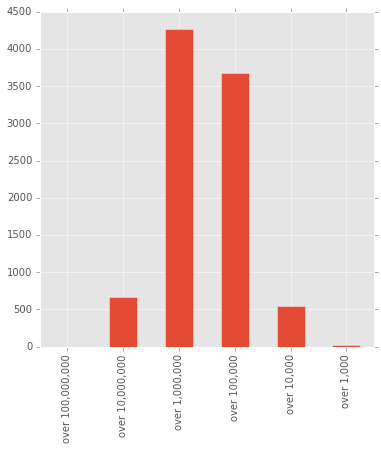

In [88]:
t=(transfers.groupby('id')['feeValue'].max()+1).apply(math.log10).apply(math.floor).value_counts().sort_index(ascending=False).drop(0)
t.index = t.index.map(lambda x: "over "+locale.format("%d",int(math.pow(10,x)),grouping=True))

t.plot.bar(figsize=(6,6))

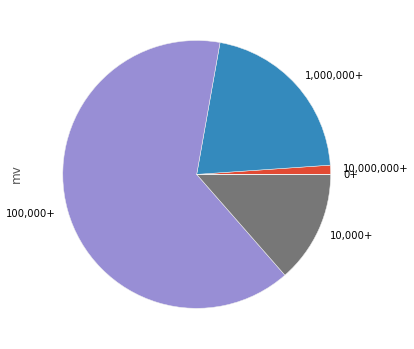

In [111]:
t=(nonloans['mv']+1).apply(math.log10).apply(math.floor).value_counts().sort_index(ascending=False)#.drop(3)
t.index = t.index.map(lambda x: locale.format("%d",int(math.pow(10,x) if x>1 else 0),grouping=True)+'+')

t.plot.pie(figsize=(6,6))

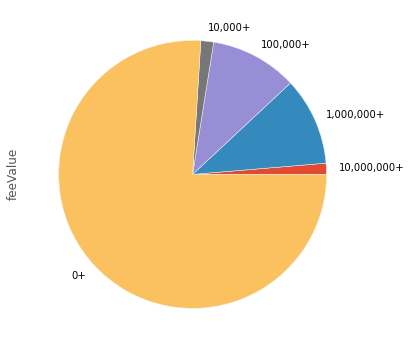

In [115]:
t=(nonloans['feeValue']+1).apply(math.log10).apply(math.floor).value_counts().sort_index(ascending=False).drop([3,8])
t.index = t.index.map(lambda x: locale.format("%d",int(math.pow(10,x) if x>1 else 0),grouping=True)+'+')

t.plot.pie(figsize=(6,6))

In [36]:
transfers = pd.read_csv('../data/merged/transfers.csv')
loans=transfers[transfers['isLoan']]
nonloans=transfers[~transfers['isLoan']]

In [94]:
transfers[transfers['fromTeamId'].isin([464,12604])]
#transfers[pd.notnull(transfers['newToCountry'])]

,id,playerName,date,season,fromCountry,fromLeague,fromTeamId,fromTeamName,toCountry,toLeague,toTeamId,toTeamName,mv,fee,feeValue,isLoan
366,6264,Ricardo Gardner,1997-07-01,1997,Jamaica,Other Jamaica,464,Own U19,Jamaica,Other Jamaica,1178,Harbour View,NaN,-,NaN,False
1783,3133,Nwankwo Kanu,1992-07-01,1992,Nigeria,Other Nigeria,464,Own U19,Nigeria,Other Nigeria,11321,FC Heartland,NaN,-,NaN,False
2162,3189,Laurén,1995-07-01,1995,Spain,Other Spain,464,Own U19,Spain,Other Spain,6685,Utrera,NaN,-,NaN,False
2414,13467,Richard Jackson,1997-07-01,1997,England,Other England,464,Own U19,England,Other England,971,Scarborough Athletic,NaN,-,NaN,False
3680,24485,Idan Tal,1994-07-01,1994,Israel,Other Israel,464,Own U19,Israel,Other Israel,17580,H. Jerusalem,NaN,?,NaN,False
4297,3692,Jussi Jääskeläinen,1994-05-01,1993,Finland,Other Finland,464,Own U19,Finland,Other Finland,3778,Mikkelin Kissat,NaN,-,NaN,False
6378,3199,Rami Shaaban,1994-01-01,1993,Sweden,Other Sweden,464,Own U19,Sweden,Other Sweden,8585,Saltsjöbadens,NaN,-,NaN,False
6705,3806,Jihai Sun,1995-07-01,1995,China,Other China,464,Own U19,China,Other China,3178,DL Shide,NaN,-,NaN,False
7795,3800,Édouard Cissé,1996-07-01,1996,France,Other France,464,Own U19,France,Other France,3166,FC Pau,NaN,-,NaN,False
8001,3374,Njitap Geremi,1995-07-01,1995,Cameroon,Other Cameroon,464,Own U19,Cameroon,Other Cameroon,3320,Racing Bafoussam,NaN,-,NaN,False


In [38]:
#transfers['toCountry'] = 
transfers['newToCountry']=np.where(transfers['fromTeamId'].isin([75,123,515,2113,2077]),transfers['fromCountry'],transfers['toCountry'])

In [5]:
transfers[transfers['toTeamId']==515]

,id,playerName,date,season,fromCountry,fromLeague,fromTeamId,fromTeamName,toCountry,toLeague,toTeamId,toTeamName,mv,fee,feeValue,isLoan
5,4115,Chris Baird,2014-01-31,2013,England,GB2,1032,Reading,NaN,NaN,515,Unattached,700000,-,NaN,False
19,4265,James Scowcroft,2010-07-01,2010,England,NaN,1150,Leyton Orient,NaN,NaN,515,Unattached,1000000,-,NaN,False
129,3179,Carlton Cole,2015-07-01,2015,England,GB1,379,West Ham,NaN,NaN,515,Unattached,1500000,-,NaN,False
131,3179,Carlton Cole,2013-07-01,2013,England,GB1,379,West Ham,NaN,NaN,515,Unattached,3500000,-,NaN,False
155,3266,Jérémie Aliadière,2010-07-01,2010,England,GB2,641,Middlesbrough,NaN,NaN,515,Unattached,3000000,-,NaN,False
168,3447,Ragnvald Soma,2013-07-01,2013,Denmark,NaN,369,Lyngby BK,NaN,NaN,515,Unattached,100000,-,NaN,False
171,3447,Ragnvald Soma,2012-07-01,2012,Austria,A1,170,Rapid Vienna,NaN,NaN,515,Unattached,350000,-,NaN,False
233,16169,Jermaine Johnson,2015-01-01,2014,United States,NAFC,39148,Indy Eleven,NaN,NaN,515,Unattached,250000,-,NaN,False
243,3946,Jeff Smith,2011-07-01,2011,Belgium,NaN,3146,Ol. Charleroi,NaN,NaN,515,Unattached,75000,-,NaN,False
261,4039,Dean Leacock,2015-07-01,2015,England,NaN,3537,Crawley Town,NaN,NaN,515,Unattached,250000,-,NaN,False


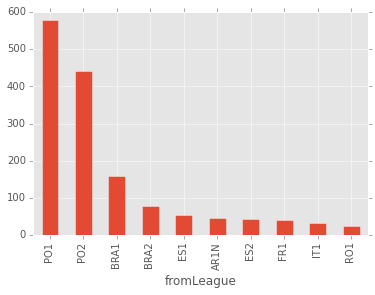

In [95]:
nonloans['PO1'==nonloans['toLeague']].groupby('fromLeague').count().sort_values('id',ascending=False)['id'][:10].plot.bar()

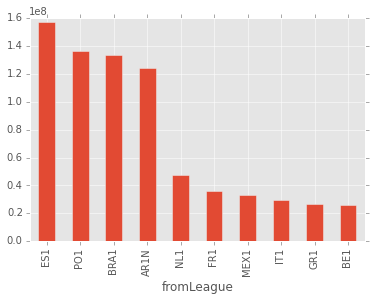

In [96]:
nonloans['PO1'==nonloans['toLeague']].groupby('fromLeague').sum().sort_values('feeValue',ascending=False)['feeValue'][:10].plot.bar()

In [489]:
pre2001ids = transfers[transfers['season']<2001]['id'].drop_duplicates().tolist()
transfers[transfers['id'].apply(lambda i: not i in pre2001ids)]

,id,playerName,date,season,fromCountry,fromLeague,fromTeamId,fromTeamName,toCountry,toLeague,toTeamId,toTeamName,mv,fee,feeValue,isLoan
161,4115,Chris Baird,2016-05-02,2015,England,GB2,931,Fulham FC,England,GB2,22,Derby,500000,End of loan,0,True
162,4115,Chris Baird,2016-02-18,2015,England,GB2,22,Derby,England,GB2,931,Fulham FC,500000,Loan,0,False
163,4115,Chris Baird,2015-07-01,2015,England,GB1,984,West Brom,England,GB2,22,Derby,500000,Free transfer,0,False
164,4115,Chris Baird,2014-07-07,2014,England,GB2,1132,Burnley FC,England,GB1,984,West Brom,700000,Free transfer,0,False
165,4115,Chris Baird,2014-03-20,2013,England,NaN,515,Unattached,NaN,GB2,1132,Burnley FC,700000,-,NaN,False
166,4115,Chris Baird,2014-01-31,2013,England,GB2,1032,Reading,NaN,NaN,515,Unattached,700000,-,NaN,False
167,4115,Chris Baird,2013-09-20,2013,England,GB2,931,Fulham FC,England,GB2,1032,Reading,1000000,Free transfer,0,False
168,4115,Chris Baird,2007-07-12,2007,England,GB1,180,Southampton,England,GB2,931,Fulham FC,750000,"4,50 Mill. €",4500000,False
169,4115,Chris Baird,2004-05-10,2003,England,GB1,1010,Watford,England,GB1,180,Southampton,NaN,End of loan,0,True
170,4115,Chris Baird,2004-03-17,2003,England,GB1,180,Southampton,England,GB1,1010,Watford,NaN,Loan,0,False


In [483]:
transfers['id'].drop_duplicates().count()-8513

18399

In [501]:
players.to_csv('../data/merged/players.csv',encoding='utf-8',index=False)

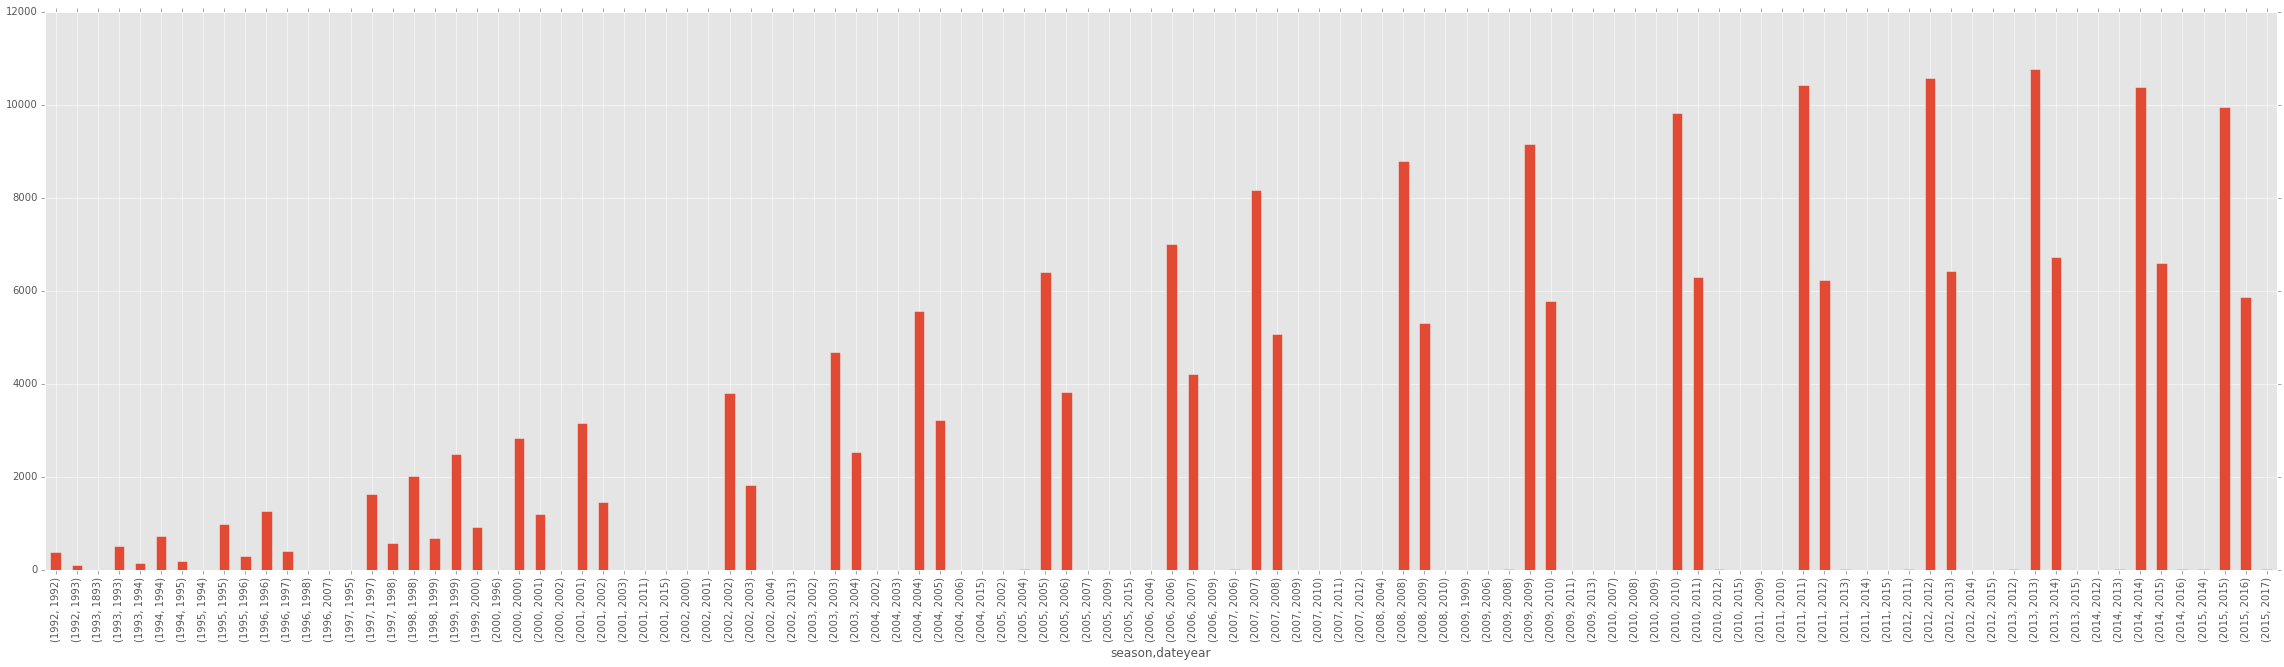

In [97]:
# irregular transfers (where transfer date is outside of season years) are negligible
transfers.join(transfers['date'].apply(lambda d:d.year),rsuffix='year').groupby(['season','dateyear']).count()['id'].plot.bar(figsize=(40,10))

In [469]:
transfers.merge(clubs.rename(columns={'league': 'fromLeague','clubId':'fromTeamId'})[['fromTeamId','season','fromLeague']],how='left',on=['season','fromTeamId']) \
                .merge(clubs.rename(columns={'league': 'toLeague','clubId':'toTeamId'})[['toTeamId','season','toLeague']],how='left',on=['season','toTeamId'])

,id,playerName,date,season,fromCountry,fromTeamId,fromTeamName,toCountry,toTeamId,toTeamName,mv,fee,feeValue,isLoan,fromLeague,toLeague
0,4096,Jacob Burns,2014-07-01,2014,Australia,970,Perth Glory,NaN,123,End of career,300000,-,NaN,False,AUS1,NaN
1,4096,Jacob Burns,2009-07-01,2009,Romania,10442,Unirea Urziceni,Australia,970,Perth Glory,400000,Free transfer,0,False,NaN,AUS1
2,4096,Jacob Burns,2008-02-01,2007,Poland,422,Wisla Kraków,Romania,10442,Unirea Urziceni,450000,Free transfer,0,False,PL1,NaN
3,4096,Jacob Burns,2006-02-01,2005,England,349,Barnsley FC,Poland,422,Wisla Kraków,400000,100 Th. €,100000,False,GB3,PL1
4,4096,Jacob Burns,2004-01-01,2003,England,515,Unattached,NaN,349,Barnsley FC,NaN,-,NaN,False,NaN,GB3
5,4096,Jacob Burns,2003-07-01,2003,England,399,Leeds,NaN,515,Unattached,NaN,-,NaN,False,GB2,NaN
6,4096,Jacob Burns,2000-07-01,2000,Australia,2500,Parra. Power,England,399,Leeds,NaN,375 Th. €,375000,False,NaN,NaN
7,4096,Jacob Burns,1999-07-01,1999,Australia,6045,Sydney United,Australia,2500,Parra. Power,NaN,?,NaN,False,NaN,NaN
8,4097,Kevin Lisbie,2016-01-11,2015,England,2804,Barnet,NaN,515,Unattached,150000,-,NaN,False,NaN,NaN
9,4097,Kevin Lisbie,2015-07-01,2015,England,1150,Leyton Orient,England,2804,Barnet,150000,Free transfer,0,False,NaN,NaN


In [459]:
transfers

,id,playerName,date,season,fromCountry,fromTeamId,fromTeamName,toCountry,toTeamId,toTeamName,mv,fee,feeValue,isLoan
0,4096,Jacob Burns,2014-07-01,2014,Australia,970,Perth Glory,NaN,123,End of career,300000,-,NaN,False
1,4096,Jacob Burns,2009-07-01,2009,Romania,10442,Unirea Urziceni,Australia,970,Perth Glory,400000,Free transfer,0,False
2,4096,Jacob Burns,2008-02-01,2007,Poland,422,Wisla Kraków,Romania,10442,Unirea Urziceni,450000,Free transfer,0,False
3,4096,Jacob Burns,2006-02-01,2005,England,349,Barnsley FC,Poland,422,Wisla Kraków,400000,100 Th. €,100000,False
4,4096,Jacob Burns,2004-01-01,2003,England,515,Unattached,NaN,349,Barnsley FC,NaN,-,NaN,False
5,4096,Jacob Burns,2003-07-01,2003,England,399,Leeds,NaN,515,Unattached,NaN,-,NaN,False
6,4096,Jacob Burns,2000-07-01,2000,Australia,2500,Parra. Power,England,399,Leeds,NaN,375 Th. €,375000,False
7,4096,Jacob Burns,1999-07-01,1999,Australia,6045,Sydney United,Australia,2500,Parra. Power,NaN,?,NaN,False
8,4097,Kevin Lisbie,2016-01-11,2015,England,2804,Barnet,NaN,515,Unattached,150000,-,NaN,False
9,4097,Kevin Lisbie,2015-07-01,2015,England,1150,Leyton Orient,England,2804,Barnet,150000,Free transfer,0,False


In [123]:
players.columns

Index([u'2nd club', u'2nd club id', u'Age', u'Complete name',
       u'Contract option', u'Contract there until', u'Contract until',
       u'Country of birth', u'Current club', u'Current club id',
       u'Date of birth', u'Date of last contract extension',
       u'Detailed position', u'Display name', u'Foot', u'Glove', u'Height',
       u'In the team since', u'Intl caps/goals', u'Name in home country',
       u'National team id', u'Nationality', u'Outfitter', u'Place of birth',
       u'Player's agent', u'Player's agent id', u'Position', u'Shoe model',
       u'Shoe size', u'birthDate', u'day of death', u'error', u'facebook',
       u'filename', u'id', u'instagram', u'name', u'on loan from',
       u'on loan from club id', u'twitter', u'website'],
      dtype='object')

In [74]:
players[(pd.isnull(players['Display name']))].groupby('error').count()

,2nd club,2nd club id,Age,Complete name,Contract option,Contract there until,Contract until,Country of birth,Current club,Current club id,...,day of death,facebook,filename,id,instagram,name,on loan from,on loan from club id,twitter,website
error,,,,,,,,,,,,,,,,,,,,,
'NoneType' object has no attribute 'find_all',0,0,0,0,0,0,0,0,0,0,...,0,0,80,80,0,79,0,0,0,0


In [51]:
transfers

,id,playerName,date,season,fromCountry,fromTeamId,fromTeamName,toCountry,toTeamId,toTeamName,mv,fee,isLoan
0,4096,Jacob Burns,2014-07-01,14/15,Australia,970,Perth Glory,NaN,123,End of career,300000,-,False
1,4096,Jacob Burns,2009-07-01,09/10,Romania,10442,Unirea Urziceni,Australia,970,Perth Glory,400000,Free transfer,False
2,4096,Jacob Burns,2008-02-01,07/08,Poland,422,Wisla Kraków,Romania,10442,Unirea Urziceni,450000,Free transfer,False
3,4096,Jacob Burns,2006-02-01,05/06,England,349,Barnsley FC,Poland,422,Wisla Kraków,400000,100 Th. €,False
4,4096,Jacob Burns,2004-01-01,03/04,England,515,Unattached,NaN,349,Barnsley FC,NaN,-,False
5,4096,Jacob Burns,2003-07-01,03/04,England,399,Leeds,NaN,515,Unattached,NaN,-,False
6,4096,Jacob Burns,2000-07-01,00/01,Australia,2500,Parra. Power,England,399,Leeds,NaN,375 Th. €,False
7,4096,Jacob Burns,1999-07-01,99/00,Australia,6045,Sydney United,Australia,2500,Parra. Power,NaN,?,False
8,4097,Kevin Lisbie,2016-01-11,15/16,England,2804,Barnet,NaN,515,Unattached,150000,-,False
9,4097,Kevin Lisbie,2015-07-01,15/16,England,1150,Leyton Orient,England,2804,Barnet,150000,Free transfer,False


In [196]:
t=transfers[['fromTeamId','fromTeamName','id']].drop_duplicates(['fromTeamId','fromTeamName'])
s=t.groupby('fromTeamId').count().sort_values('id')
t[t['fromTeamId'].apply(lambda x:x in s[s['id']>1].index)].sort_values('fromTeamId')


,fromTeamId,fromTeamName,id
1358,1,Saarbrücken,1529
53962,1,SaarbrÃ¼cken,17
1077,3,1. FC Köln,2888
54078,3,1. FC KÃ¶ln,36
560,5,Milan,4291
554,5,AC Milan,4291
1009,13,Atlético Madrid,7979
33481,13,AtlÃ©tico Madrid,7577
66502,38,F. DÃ¼sseldorf,1978
7167,38,F. Düsseldorf,2902


In [197]:
t=transfers[['toTeamId','toTeamName','id']].drop_duplicates(['toTeamId','toTeamName'])
s=t.groupby('toTeamId').count().sort_values('id')
t[t['toTeamId'].apply(lambda x:x in s[s['id']>1].index)].sort_values('toTeamId')


,toTeamId,toTeamName,id
53963,1,SaarbrÃ¼cken,17
1359,1,Saarbrücken,1529
1078,3,1. FC Köln,2888
54079,3,1. FC KÃ¶ln,36
559,5,Milan,4291
555,5,AC Milan,4291
1010,13,Atlético Madrid,7979
33482,13,AtlÃ©tico Madrid,7577
15835,21,Chemnitzer FC,63
55796,21,Karl-Marx-Stadt,406


In [1]:
teams = pd.concat([DataFrame(nonloans[['fromTeamId','fromTeamName','fromCountry']].values,columns=['teamId','teamName','country']),
    DataFrame(nonloans[['toTeamId','toTeamName','toCountry']].values,columns=['teamId','teamName','country'])],ignore_index=True).drop_duplicates('teamId')

teams.groupby('country').count()

NameError: name 'pd' is not defined

In [251]:
import math
math.log10(10)

1.0

In [ ]:
transfers[pd.isnull(transfers['playerName'])]

In [162]:
grouped = transfers.groupby(['id','date'])['playerName'].count()
grouped[grouped==2].count()

194

In [234]:
int('0' + ''.join([d for d in 'asds121' if d in '1234567890.']))

121

In [235]:
transfers[['id','fee','playerName']][~((transfers['fee'].str.contains('Th.'))|(transfers['fee'].str.contains('Mill.')))].drop_duplicates(subset='fee')
transfers[['id','fee','playerName']][~((transfers['fee'].str.contains('Th.'))|(transfers['fee'].str.contains('Mill.')))].groupby('fee').count().sort_values('id',ascending=False)

#transfers[['mvfixed','mv']].describe()

,id,playerName
fee,,
Free transfer,58402,58402
-,45428,45428
?,37588,37588
End of loan,29989,29989
Loan,28254,28254
draft,608,608
Swap deal,604,604
gratuito,331,331
trade,226,226


In [280]:
(transfers.groupby('fromCountry')['id'].nunique() + transfers.groupby('toCountry')['id'].nunique()).sort_values(ascending=False)[:40].index

England                 11891
France                   7259
Italy                    7191
Germany                  6880
Spain                    6851
Belgium                  6134
Turkey                   5848
Netherlands              5823
Portugal                 5161
Russia                   4208
United States            4060
Brazil                   2840
Greece                   2154
Scotland                 1955
Argentina                1508
Switzerland              1501
Cyprus                   1262
Romania                  1122
Denmark                   950
Sweden                    941
Austria                   909
Norway                    892
Serbia                    889
Ukraine                   864
Poland                    812
Mexico                    763
Bulgaria                  691
Croatia                   655
Israel                    643
China                     634
Hungary                   578
Czech Republic            573
Uruguay                   564
Australia 

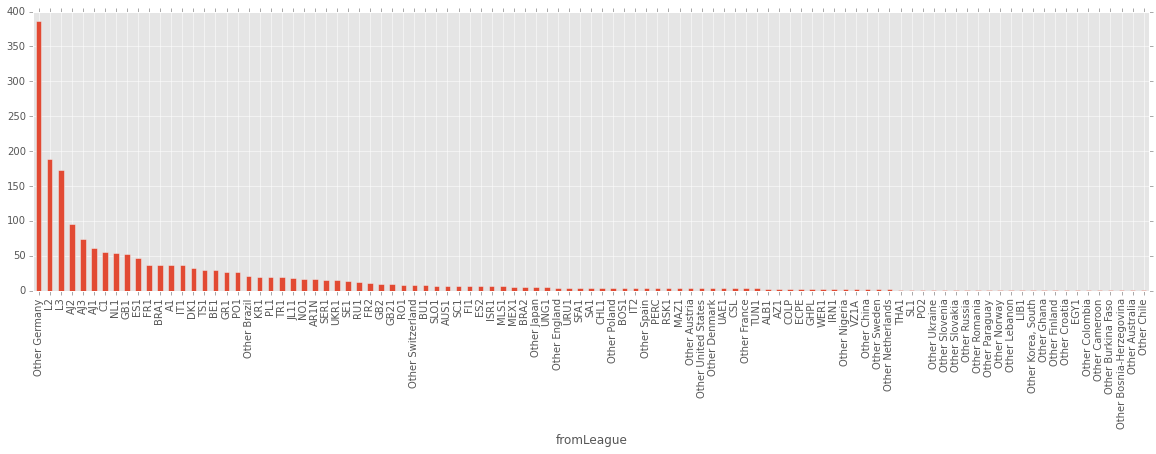

In [115]:
transfers[((transfers['toLeague'] != transfers['fromLeague']))&(transfers['toLeague'] == 'L1')&(transfers['season'] > 2000)].drop_duplicates(subset=['id'],keep='last').groupby('fromLeague')['id'].count().sort_values(ascending=False).plot.bar(figsize=(20,5))

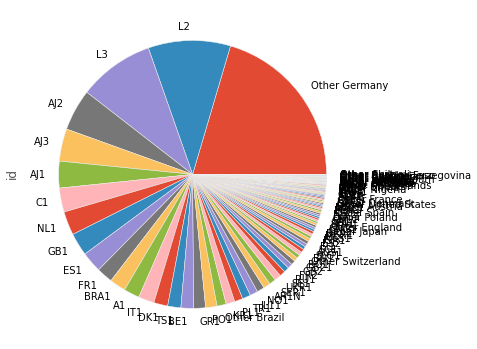

In [114]:
transfers[((transfers['toLeague'] != transfers['fromLeague']))&(transfers['toLeague'] == 'L1')&(transfers['season'] > 2000)].drop_duplicates(subset=['id'],keep='last').groupby('fromLeague')['id'].count().sort_values(ascending=False).plot.pie(figsize=(6,6))

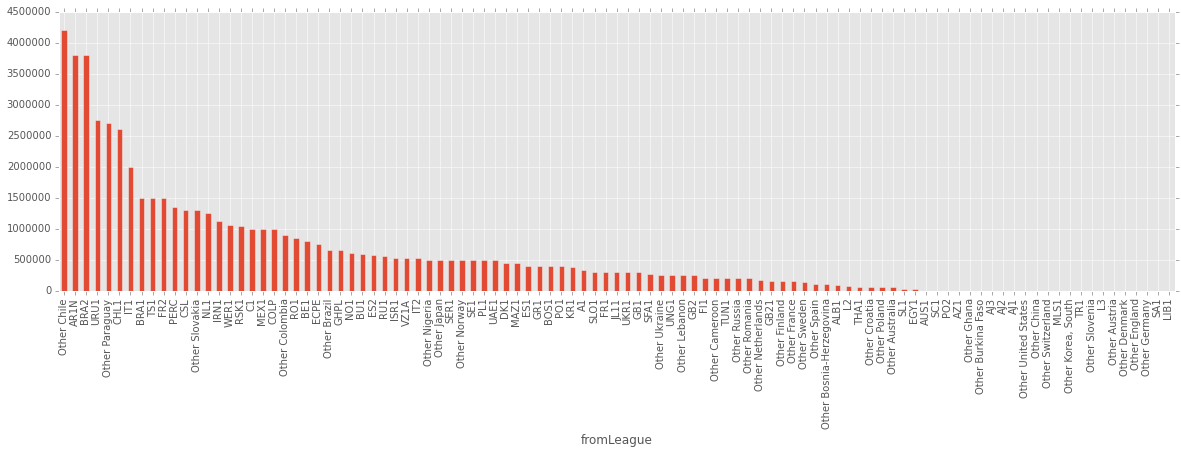

In [122]:
transfers[((transfers['toLeague'] != transfers['fromLeague']))&(transfers['toLeague'] == 'L1')&(transfers['season'] > 2000)].drop_duplicates(subset=['id'],keep='last').groupby('fromLeague')['feeValue'].median().sort_values(ascending=False).plot.bar(figsize=(20,5))

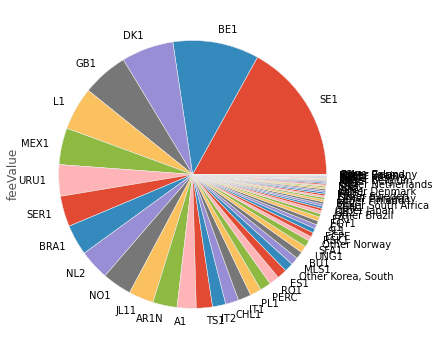

In [116]:
transfers[((transfers['toLeague'] != transfers['fromLeague']))&(transfers['toLeague'] == 'NL1')&(transfers['season'] > 2000)].drop_duplicates(subset=['id'],keep='last').groupby('fromLeague')['feeValue'].sum().sort_values(ascending=False).plot.pie(figsize=(6,6))

In [124]:
transfers[((transfers['fromLeague'] == 'Other Paraguay'))&(transfers['toLeague'] == 'L1')&(transfers['season'] > 2000)].drop_duplicates(subset=['id'],keep='last').sort_values('feeValue',ascending=False)

,id,playerName,date,season,fromCountry,fromLeague,fromTeamId,fromTeamName,toCountry,toLeague,toTeamId,toTeamName,mv,fee,feeValue,isLoan
64836,28944,Julio dos Santos,2006-01-01,2005,Paraguay,Other Paraguay,1214,Cerro Porteño,Germany,L1,27,Bayern Munich,2000000,"2,70 Mill. €",2700000,False


In [126]:
transfers[transfers['id']==28944]

,id,playerName,date,season,fromCountry,fromLeague,fromTeamId,fromTeamName,toCountry,toLeague,toTeamId,toTeamName,mv,fee,feeValue,isLoan
64827,28944,Julio dos Santos,2015-01-01,2014,Paraguay,Other Paraguay,1214,Cerro Porteño,Brazil,BRA1,978,Vasco da Gama,500000,?,NaN,False
64828,28944,Julio dos Santos,2009-07-01,2009,Brazil,BRA1,679,Atlético-PR,Paraguay,Other Paraguay,1214,Cerro Porteño,500000,?,NaN,False
64829,28944,Julio dos Santos,2008-07-01,2008,Germany,L1,27,Bayern Munich,Brazil,BRA1,679,Atlético-PR,400000,Free transfer,0,False
64830,28944,Julio dos Santos,2008-06-30,2007,Brazil,BRA1,210,Grêmio,Germany,L1,27,Bayern Munich,400000,End of loan,0,True
64831,28944,Julio dos Santos,2008-01-01,2007,Germany,L1,27,Bayern Munich,Brazil,BRA1,210,Grêmio,1000000,Loan,0,True
64832,28944,Julio dos Santos,2007-12-01,2007,Spain,ES1,3302,UD Almería,Germany,L1,27,Bayern Munich,1000000,End of loan,0,True
64833,28944,Julio dos Santos,2007-08-01,2007,Germany,L1,27,Bayern Munich,Spain,ES1,3302,UD Almería,1500000,Loan fee:950 Th. €,950000,False
64834,28944,Julio dos Santos,2007-06-30,2006,Germany,L1,82,VfL Wolfsburg,Germany,L1,27,Bayern Munich,1500000,End of loan,0,True
64835,28944,Julio dos Santos,2007-01-01,2006,Germany,L1,27,Bayern Munich,Germany,L1,82,VfL Wolfsburg,1500000,Loan,0,True
64836,28944,Julio dos Santos,2006-01-01,2005,Paraguay,Other Paraguay,1214,Cerro Porteño,Germany,L1,27,Bayern Munich,2000000,"2,70 Mill. €",2700000,False


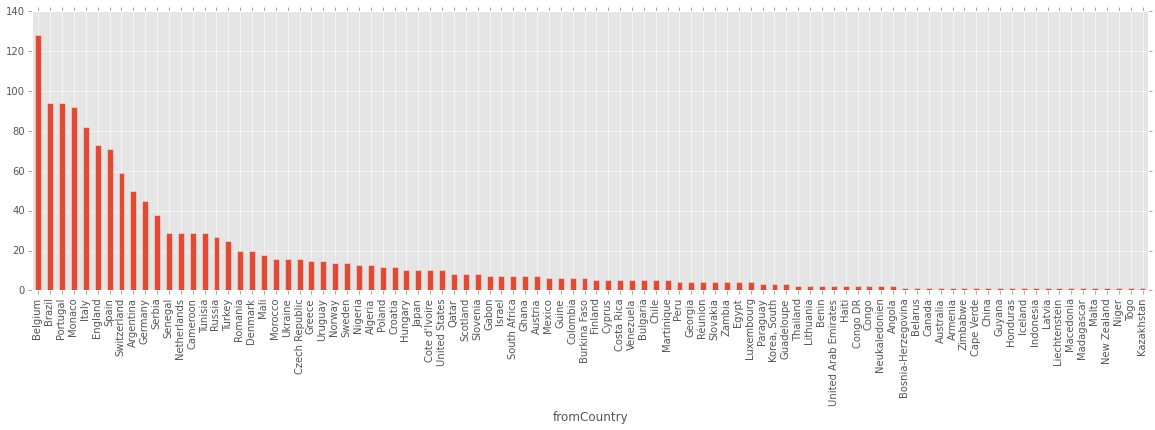

In [240]:
transfers[(transfers['toCountry'] == 'France') & (transfers['date'] >= datetime.date(1980,1,1))].drop_duplicates(subset=['id'],keep='last').groupby('fromCountry')['id'].count().drop('France').sort_values(ascending=False).plot.bar(figsize=(20,5))

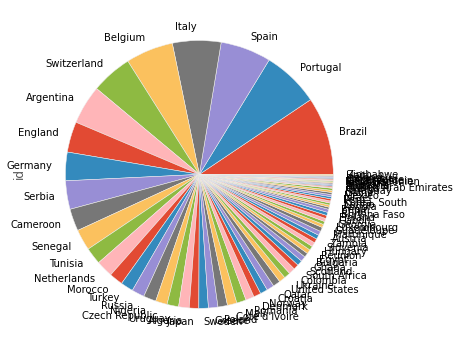

In [209]:
transfers[(transfers['toCountry'] == 'France') & (transfers['date'] < datetime.date(2010,1,1))].drop_duplicates(subset=['id'],keep='last').groupby('fromCountry')['id'].count().drop(['France','Monaco']).sort_values(ascending=False).plot.pie(figsize=(6,6))

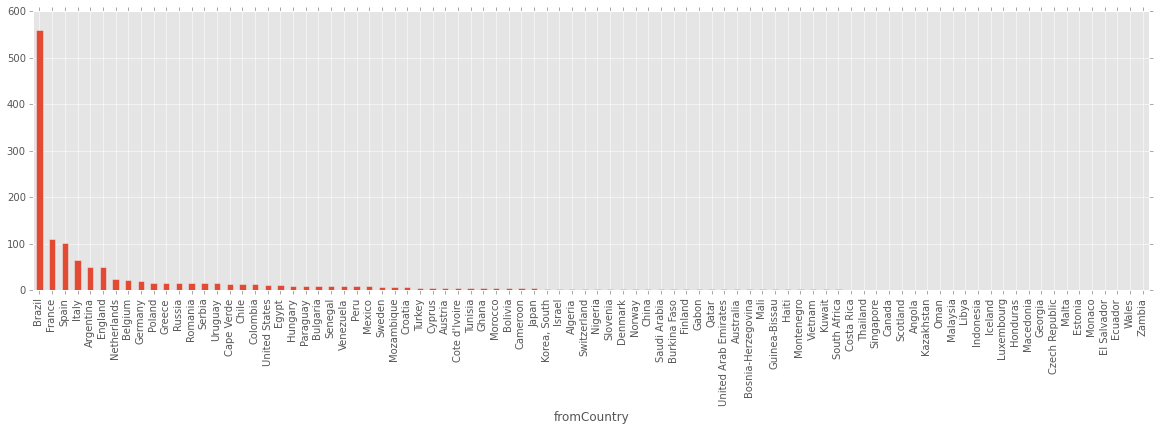

In [185]:
transfers[(transfers['toCountry'] == 'Portugal') & (transfers['date'] >= datetime.date(1900,1,1))].drop_duplicates(subset=['id'],keep='last').groupby('fromCountry')['id'].count().drop('Portugal').sort_values(ascending=False).plot.bar(figsize=(20,5))

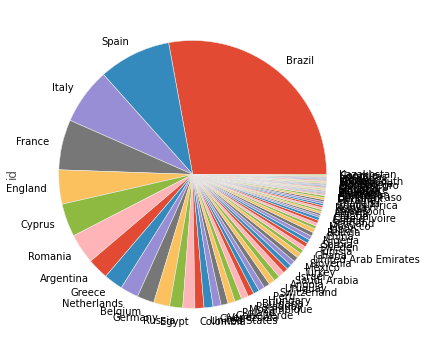

In [205]:
transfers[(transfers['toCountry'] == 'Portugal') & (transfers['date'] >= datetime.date(2010,1,1))].drop_duplicates(subset=['id'],keep='last').groupby('fromCountry')['id'].count().drop('Portugal').sort_values(ascending=False).plot.pie(figsize=(6,6))

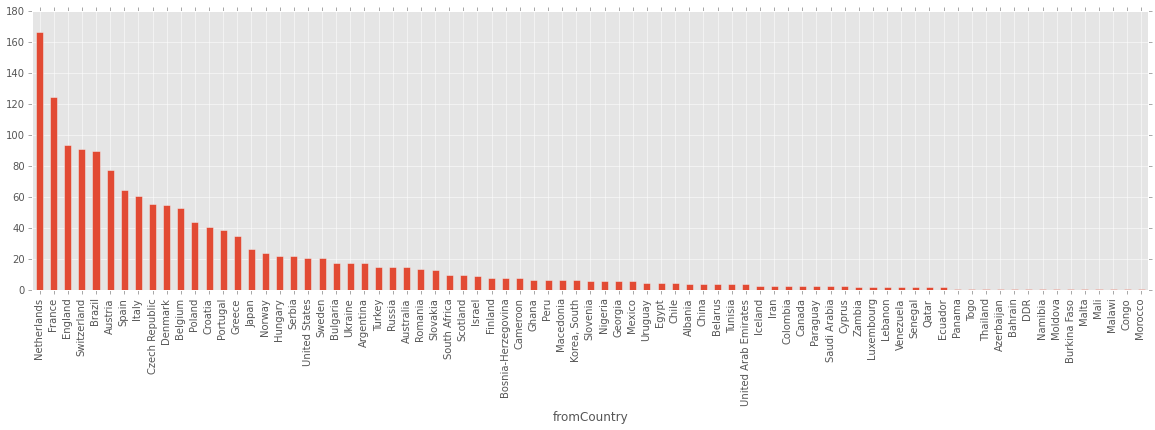

In [193]:
transfers[(transfers['toCountry'] == 'Germany') & (transfers['date'] < datetime.date(2020,1,1))].drop_duplicates(subset=['id'],keep='last').groupby('fromCountry')['id'].count().drop('Germany').sort_values(ascending=False).plot.bar(figsize=(20,5))

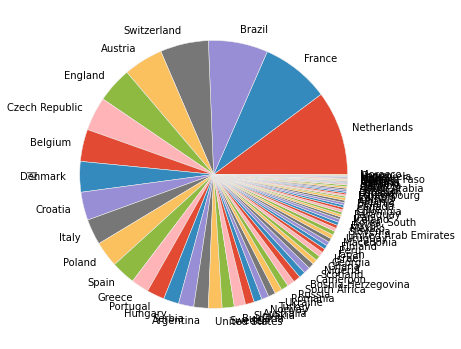

In [202]:
transfers[(transfers['toCountry'] == 'Germany') & (transfers['date'] < datetime.date(2010,1,1))].drop_duplicates(subset=['id'],keep='last').groupby('fromCountry')['id'].count().drop('Germany').sort_values(ascending=False).plot.pie(figsize=(6,6))

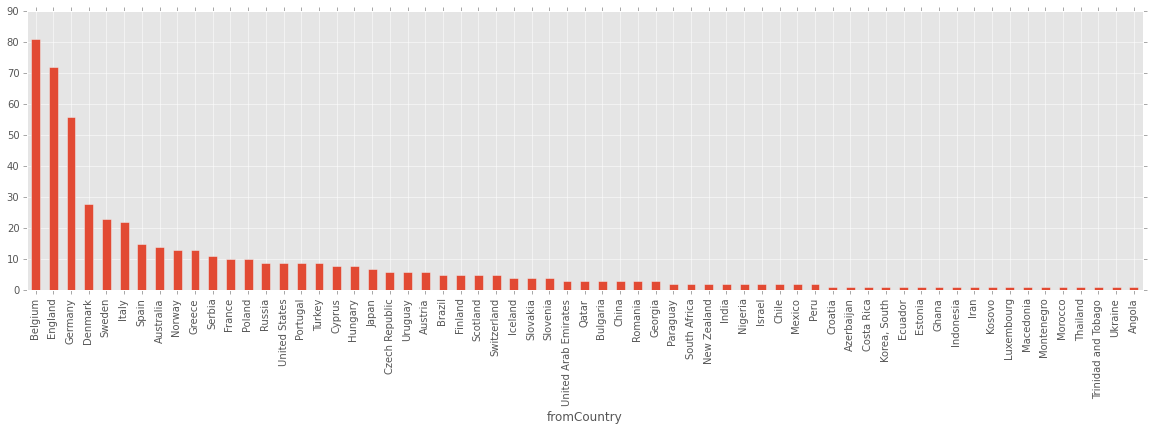

In [197]:
transfers[(transfers['toCountry'] == 'Netherlands') & (transfers['date'] >= datetime.date(2010,1,1))].drop_duplicates(subset=['id'],keep='last').groupby('fromCountry')['id'].count().drop('Netherlands').sort_values(ascending=False).plot.bar(figsize=(20,5))

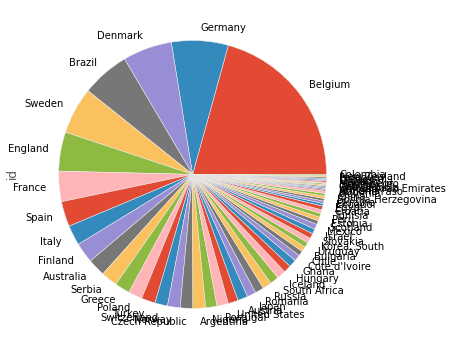

In [199]:
transfers[(transfers['toCountry'] == 'Netherlands') & (transfers['date'] < datetime.date(2010,1,1))].drop_duplicates(subset=['id'],keep='last').groupby('fromCountry')['id'].count().drop('Netherlands').sort_values(ascending=False).plot.pie(figsize=(6,6))

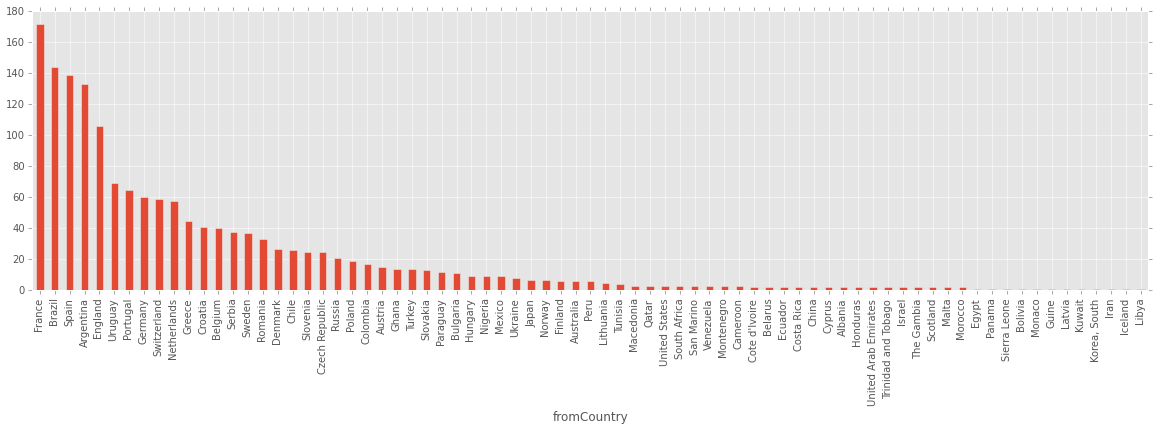

In [268]:
transfers[(transfers['toCountry'] == 'Italy') & (transfers['date'] < datetime.date(2020,1,1))].drop_duplicates(subset=['id'],keep='last').groupby('fromCountry')['id'].count().drop('Italy').sort_values(ascending=False).plot.bar(figsize=(20,5))

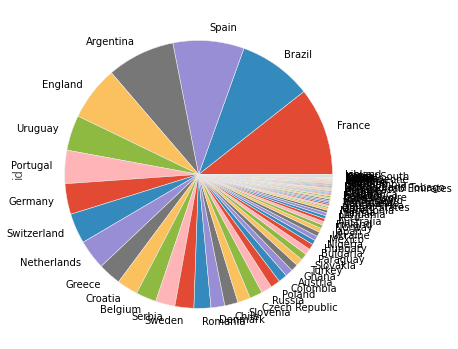

In [271]:
transfers[(transfers['toCountry'] == 'Italy') & (transfers['date'] < datetime.date(2020,1,1))].drop_duplicates(subset=['id'],keep='last').groupby('fromCountry')['id'].count().drop('Italy').sort_values(ascending=False).plot.pie(figsize=(6,6))

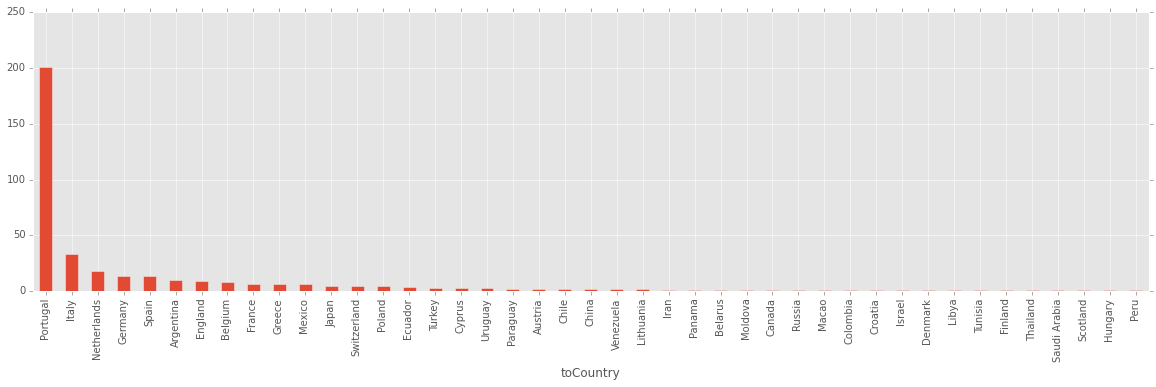

In [40]:
transfers[(transfers['fromCountry'] == 'Brazil') & (transfers['date'] < datetime.date(2020,1,1))].drop_duplicates(subset=['id'],keep='last').groupby('toCountry')['id'].count().drop('Brazil').sort_values(ascending=False).plot.bar(figsize=(20,5))

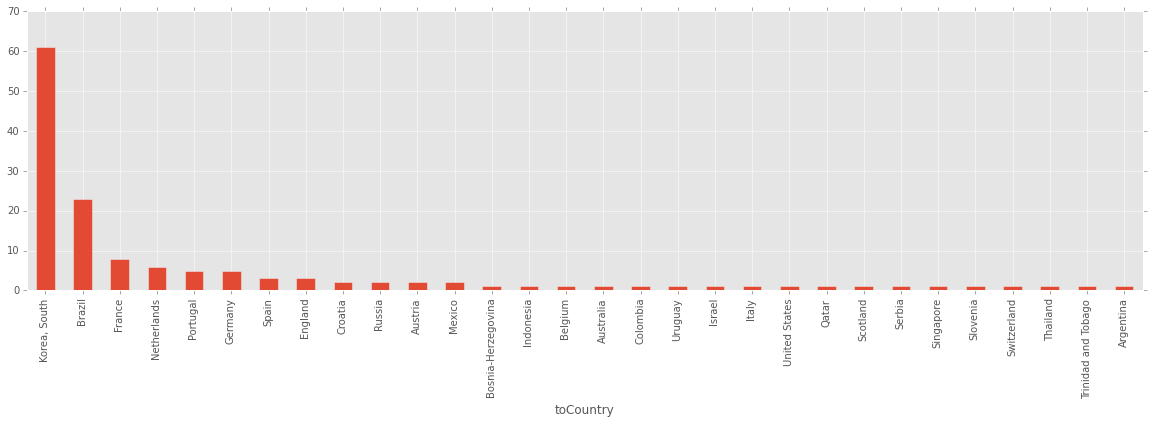

In [41]:
transfers[(transfers['fromCountry'] == 'Japan') & (transfers['date'] < datetime.date(2020,1,1))].drop_duplicates(subset=['id'],keep='last').groupby('toCountry')['id'].count().drop('Japan').sort_values(ascending=False).plot.bar(figsize=(20,5))

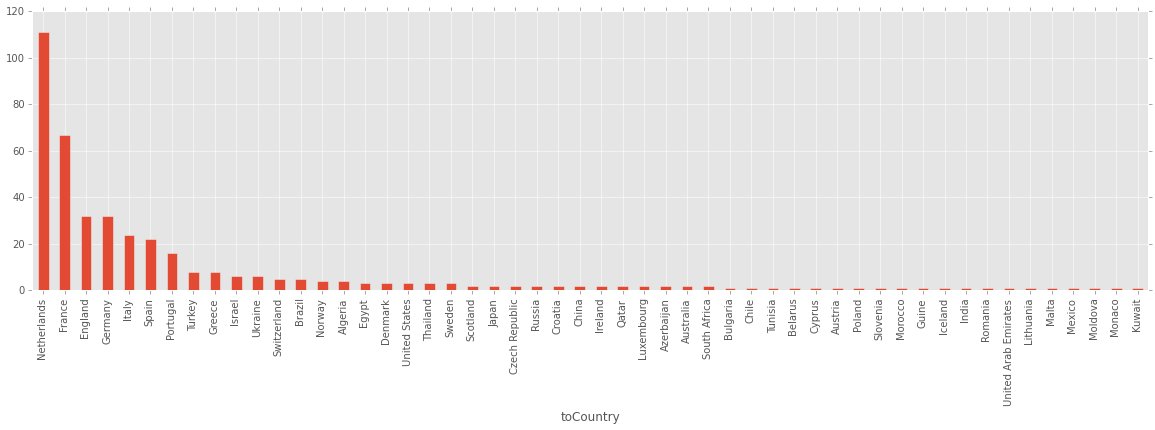

In [43]:
transfers[(transfers['fromCountry'] == 'Belgium') & (transfers['date'] < datetime.date(2020,1,1))].drop_duplicates(subset=['id'],keep='last').groupby('toCountry')['id'].count().drop('Belgium').sort_values(ascending=False).plot.bar(figsize=(20,5))

count    17184.000000
mean         7.156250
std          3.606072
min          1.000000
25%          4.750000
50%          7.000000
75%          9.000000
max         27.000000
Name: playerName, dtype: float64

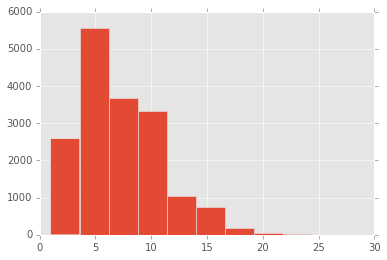

In [36]:
transfers.groupby('id')['playerName'].count().hist()
transfers.groupby('id')['playerName'].count().describe()


count    9352.000000
mean        2.162318
std         1.518207
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        15.000000
Name: playerName, dtype: float64

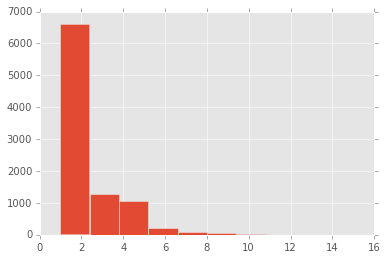

In [37]:
loans.groupby('id')['playerName'].count().hist()
loans.groupby('id')['playerName'].count().describe()


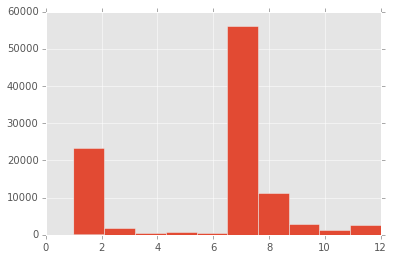

In [35]:
transfers['date'][transfers['date']>datetime.date(2002,8,1)].apply(lambda d: d.month).hist()
#.groupby('date').

In [214]:
transfers[(transfers['toCountry'] == 'France') &(transfers['fromCountry'] == 'England')].sort_values('date')

,id,playerName,date,season,fromCountry,fromTeamId,fromTeamName,toCountry,toTeamId,toTeamName,mv,fee
12493,14026,Michael Hughes,1992-07-01,92/93,England,281,Manchester City,France,667,R. Strasbourg,-,500 Th. €
117497,6979,William Prunier,1996-03-01,95/96,England,985,Manchester Utd.,France,40,G. Bordeaux,-,End of loan
1273,13248,Chris Makin,1996-07-01,96/97,England,1078,Oldham Athletic,France,244,Marseille,-,Free transfer
373,4226,Fabrizio Ravanelli,1997-07-01,97/98,England,641,Middlesbrough,France,244,Marseille,-,"7,40 Mill. €"
115113,5316,Sébastien Pérez,1999-01-01,98/99,England,164,Blackburn,France,595,SC Bastia,-,Loan
61818,3574,Valérien Ismaël,1999-01-01,98/99,England,873,Crystal Palace,France,826,Lens,-,"1,80 Mill. €"
109722,155753,Jean-Guy Wallemme,1999-01-01,98/99,England,990,Coventry City,France,750,FC Sochaux,-,?
113475,104068,Mickaël Madar,1999-01-01,98/99,England,29,Everton,France,583,Paris SG,-,?
5397,4015,Louis Saha,1999-05-31,98/99,England,762,Newcastle,France,347,FC Metz,-,End of loan
111479,5382,Jean-Claude Darcheville,1999-06-30,98/99,England,703,Nottm Forest,France,273,Rennes,-,End of loan


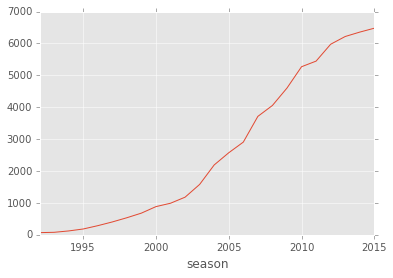

In [122]:
DataFrame(transfers[transfers['toCountry']!=transfers['fromCountry']]).groupby('season')['id'].count().plot.line()

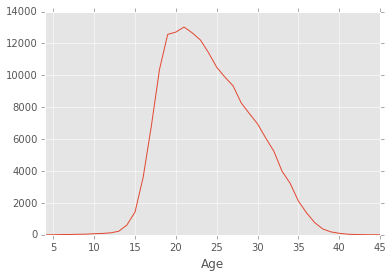

In [123]:
transfers.groupby('Age')['id'].count().plot.line()

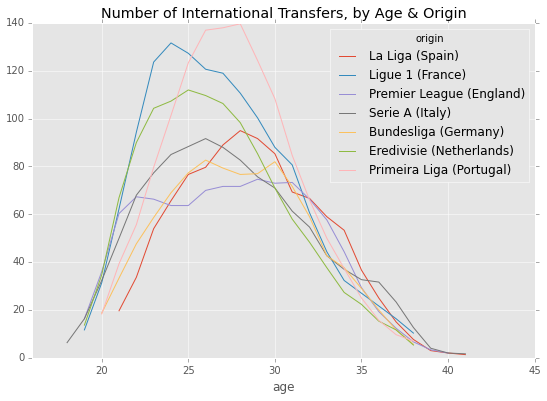

In [117]:
nonloans[(nonloans['toCountry']!=nonloans['fromCountry'])&(nonloans['fromLeague'].isin(['GB1','ES1','L1','IT1','FR1','NL1','PO1']))] \
    .rename(columns={'Age':'age','fromLeague':'origin'}).groupby(['age','origin'])['id'].count().unstack() \
    .rolling(window=3,center=False).mean().rename(columns={'GB1':'Premier League (England)','FR1':'Ligue 1 (France)','ES1':'La Liga (Spain)','IT1':'Serie A (Italy)','L1':'Bundesliga (Germany)','PO1':'Primeira Liga (Portugal)','NL1':'Eredivisie (Netherlands)'}).plot.line(figsize=(9,6),title='Number of International Transfers, by Age & Origin')


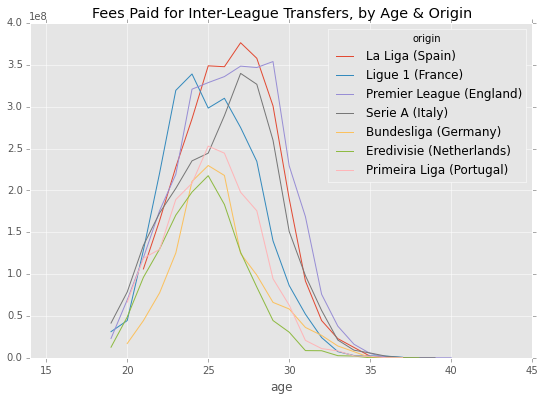

In [103]:
nonloans[(nonloans['toLeague']!=nonloans['fromLeague'])&(nonloans['fromLeague'].isin(['GB1','ES1','L1','IT1','FR1','NL1','PO1']))] \
    .rename(columns={'Age':'age','fromLeague':'origin'}).groupby(['age','origin'])['feeValue'].sum().unstack() \
    .rolling(window=3,center=False).mean().rename(columns={'GB1':'Premier League (England)','FR1':'Ligue 1 (France)','ES1':'La Liga (Spain)','IT1':'Serie A (Italy)','L1':'Bundesliga (Germany)','PO1':'Primeira Liga (Portugal)','NL1':'Eredivisie (Netherlands)'}).plot.line(figsize=(9,6),title='Fees Paid for Inter-League Transfers, by Age & Origin')


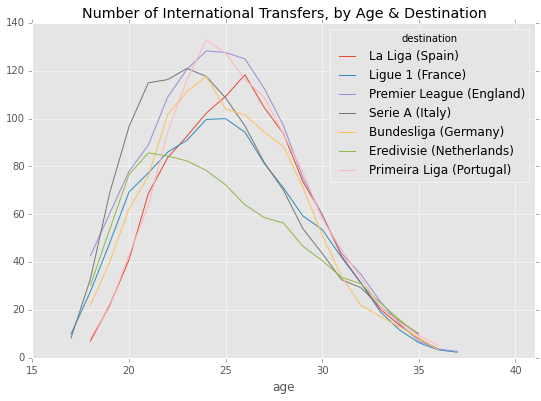

In [115]:
nonloans[(nonloans['toCountry']!=nonloans['fromCountry'])&(nonloans['toLeague'].isin(['GB1','ES1','L1','IT1','FR1','NL1','PO1']))] \
    .rename(columns={'Age':'age','toLeague':'destination'}).groupby(['age','destination'])['id'].count().unstack() \
    .rolling(window=3,center=False).mean().rename(columns={'GB1':'Premier League (England)','FR1':'Ligue 1 (France)','ES1':'La Liga (Spain)','IT1':'Serie A (Italy)','L1':'Bundesliga (Germany)','PO1':'Primeira Liga (Portugal)','NL1':'Eredivisie (Netherlands)'}).plot.line(figsize=(9,6),title='Number of International Transfers, by Age & Destination')


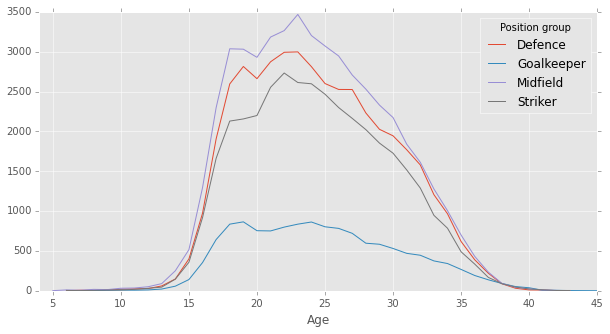

In [71]:
nonloans.groupby(['Age','Position group'])['id'].count().unstack().plot.line(figsize=(10,5))

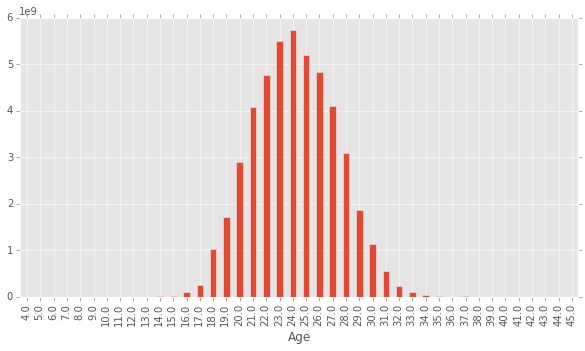

In [39]:
nonloans.groupby('Age')['feeValue'].sum().plot.bar(figsize=(10,5))

In [54]:
nonloans[nonloans['Age']<15][transfers.columns[:12].tolist()+['Age']]

,id,playerName,date,season,fromCountry,fromLeague,fromTeamId,fromTeamName,toCountry,toLeague,toTeamId,toTeamName,Age
2742,3176,Eidur Gudjohnsen,1993-07-01,1993,Iceland,Other Iceland,23656,Valur U19,Iceland,IS1,1033,Valur,14
4918,3569,Steed Malbranque,1993-07-01,1993,Belgium,Other Belgium,3488,Excelsior Mouscroun U19,France,Other France,7813,Olympique Lyon U19,13
6146,3776,Nicolás Medina,1997-01-01,1996,Argentina,Other Argentina,15100,Argentinos U20,Argentina,AR1N,1030,Argentinos,14
6218,3788,Matthew Etherington,1996-07-01,1996,England,Other England,18620,Peterb. U18,England,ENSD,1072,Peterborough,14
6671,3875,Jermain Defoe,1997-07-01,1997,England,GBJG,6932,Charlton U18,England,Other England,358,Charlton,14
10036,3467,Shaun Wright-Phillips,1996-07-01,1996,England,GBJG,12799,Not. Forest U18,England,GBJG,6930,Man City U18,14
11956,24635,Chris Eagles,2000-07-01,2000,England,GBJG,10732,FC Watford U18,England,GBJG,5242,Man Utd U18,14
13963,7717,José Antonio Reyes,1998-07-01,1998,Spain,Other Spain,28867,Sevilla FC JuvA,Spain,Other Spain,8519,Sevilla Atl.,14
15571,9915,Reto Ziegler,2000-07-01,2000,Switzerland,Other Switzerland,14179,Team Genève U17,Switzerland,Other Switzerland,14543,GC Zürich U18,14
18188,2953,Paul Scharner,1994-07-01,1994,Austria,Other Austria,20816,St. Pölten Jgd,Austria,Other Austria,48077,Purgstall Jgd.,14


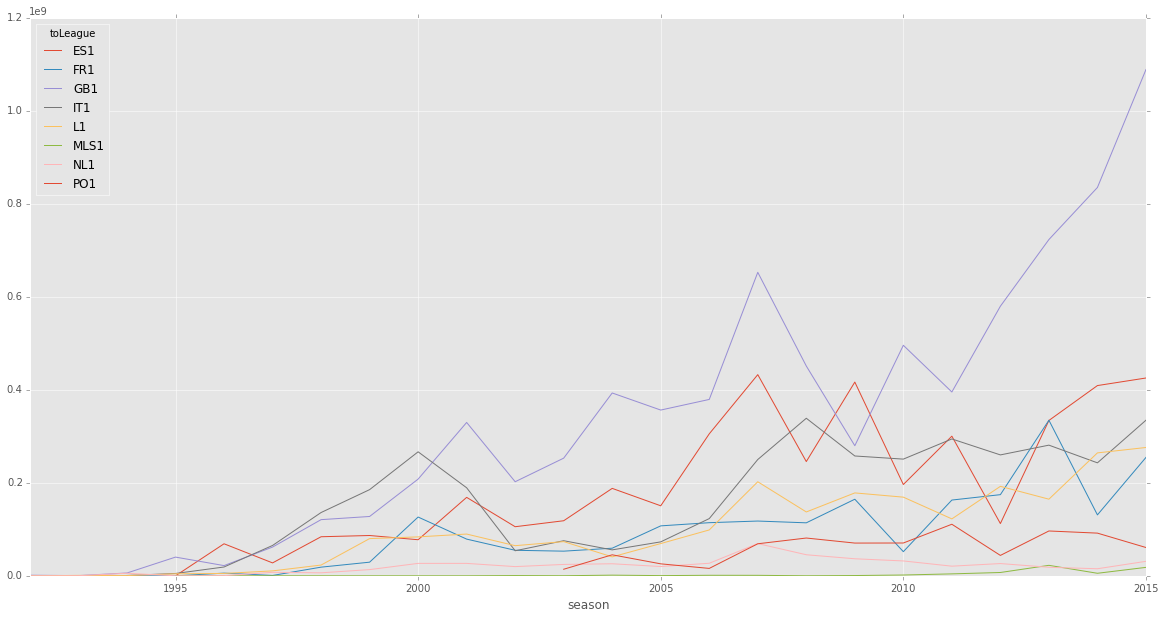

In [210]:
leagues=['GB1','ES1','L1','IT1','FR1','PO1','NL1','MLS1'] 
#DataFrame(nonloans[(nonloans['toLeague'].isin(leagues))]).groupby(['season','toLeague'])['feeValue'].sum().unstack().plot.line(figsize=(10,10))
DataFrame(nonloans[(nonloans['toLeague']!=nonloans['fromLeague'])&(nonloans['toLeague'].isin(leagues))]).groupby(['season','toLeague'])['feeValue'].sum().unstack().plot.line(figsize=(20,10))
#DataFrame(nonloans[(nonloans['toCountry']!=nonloans['fromCountry'])&(nonloans['toLeague'].isin(leagues))]).groupby(['season','toLeague'])['id'].count().unstack().plot.line(figsize=(10,10))

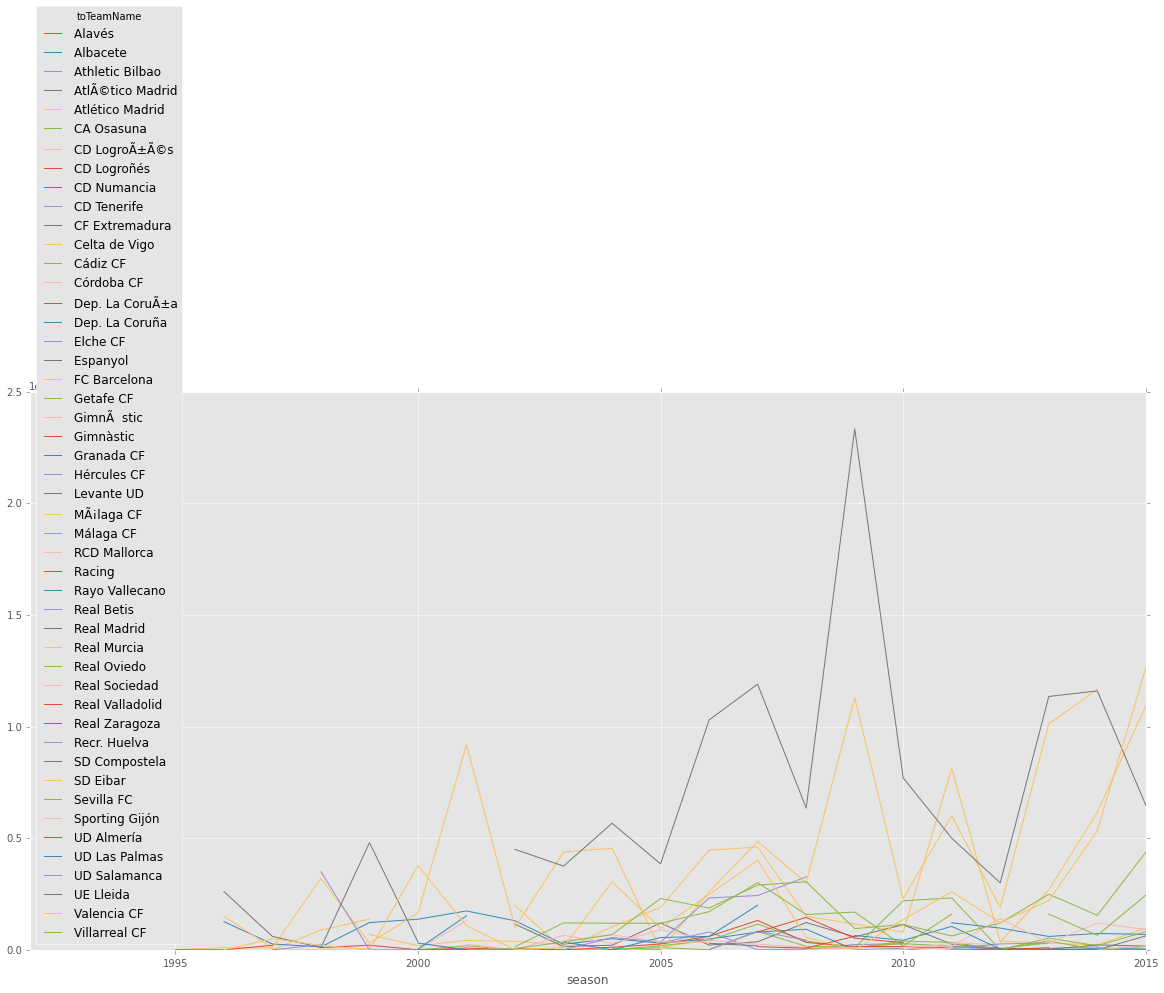

In [218]:
#DataFrame(nonloans[(nonloans['toLeague'].isin(leagues))]).groupby(['season','toLeague'])['feeValue'].sum().unstack().plot.line(figsize=(10,10))
DataFrame(nonloans[(nonloans['toLeague']!=nonloans['fromLeague'])&(nonloans['toLeague']=='ES1')]).groupby(['season','toTeamName'])['feeValue'].sum().unstack().plot.line(figsize=(20,10))
#DataFrame(nonloans[(nonloans['toCountry']!=nonloans['fromCountry'])&(nonloans['toLeague'].isin(leagues))]).groupby(['season','toLeague'])['id'].count().unstack().plot.line(figsize=(10,10))

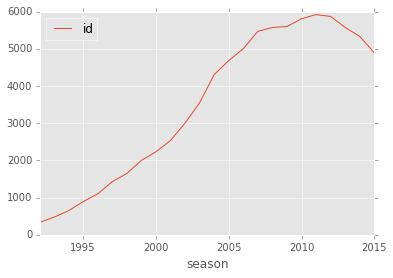

In [139]:
t=DataFrame(nonloans[nonloans['toCountry']==nonloans['fromCountry']]['season'])
t["id"]=t.index
t.groupby('season').count().plot.line()
#t.groupby('date').count()[-10:-2].plot.line()

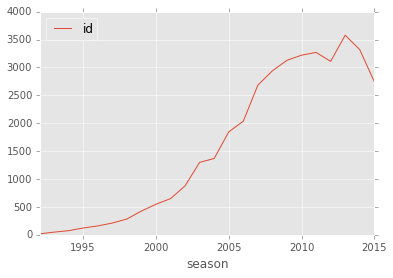

In [138]:
t=DataFrame(loans[loans['toCountry']==loans['fromCountry']]['season'])
t["id"]=t.index
t.groupby('season').count().plot.line()
#t.groupby('date').count()[-10:-2].plot.line()